In [1]:
import torch
torch.pi = torch.acos(torch.zeros(1)).item() * 2
import torch.nn as nn
import torch.nn.functional as F

import math

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [144]:
MAGIC_NUMBER = 0
class TensorToPolygon:
    
    def __call__(self, data):
        data = data.view(-1, 784)
        data = list(data.unbind())
        data = [torch.arange(784)[(x > 0.8)] for x in data]
        data = [torch.Tensor(list(x) + (351 - len(x)) * [MAGIC_NUMBER]) for x in data]
        data = torch.stack(data).contiguous()
        return data
    
    
class OneDToTwoD:
    
    def __call__(self, data):
        
        data = [torch.Tensor(x[x != MAGIC_NUMBER]) for x in data]   
        data = [torch.Tensor([list([(b // 28) - 14, (b % 28) - 14]) for b in a]) for a in data]
        data = [torch.cat((x, torch.Tensor(np.full((351 - x.shape[0],2),MAGIC_NUMBER)))) for x in data]
        data = torch.stack(data).contiguous()
        return data
    
#class Transform1d2d:
#    def __call__(self, x):
#        return torch.stack([x // 28, x % 28], -1)
    
class Transform1d2d:
    def __call__(self, x):
        return torch.stack([((x // 28) -14) * (x != MAGIC_NUMBER), ((x % 28) - 14) * (x != MAGIC_NUMBER)],-1)
        

In [146]:
def plot_preprocessing(xy):
    matrix = np.zeros(784)

    for x, y in xy[0]:
        if (x!=MAGIC_NUMBER) & (y!=MAGIC_NUMBER):
            x = int(x)+14
            y = int(y)+14
            #x = int(x)
            #y = int(y)
            index = int(x*28+y)
            matrix[index] = 1
        
    img_size = int(math.sqrt(784))
    return np.reshape(matrix, (img_size, img_size))

def plot_preprocessing1(xy):
    matrix = np.zeros(784)

    for x, y in xy[0]:
        x = int(x+14)
        y = int(y+14)
        #x = int(x)
        #y = int(y)
        index = int(x*28+y)
        if index < 784:
            matrix[index] = 1
        
    img_size = int(math.sqrt(784))
    return np.reshape(matrix, (img_size, img_size))

#plt.imshow(plot_preprocessing(default))
#print(c_mass(default)[:,0])

In [147]:
dataset1 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=None, scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
#                              OneDToTwoD()
                          ]))

dataset2 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=180, translate=None, scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
#                              OneDToTwoD()
                          ]))

dataset3 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
#                              OneDToTwoD()
                          ]))

dataset4 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=None, scale=(0.7,1.3)),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
#                              OneDToTwoD()
                          ]))

dataset5 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              #transforms.RandomAffine(degrees=0, translate=None, scale=(0.5,1.4)),
                              transforms.RandomHorizontalFlip(p=1),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
#                              OneDToTwoD()
                          ]))

In [187]:
default = dataset1[0][0]
rotated = dataset2[0][0]
translated = dataset3[0][0]
scaled = dataset4[0][0]
flipped = dataset5[0][0]

In [188]:
def moment(xy, p, q):
    x = xy[:,:, 0]
    y = xy[:,:, 1]
    x = x.pow(p) * (x != MAGIC_NUMBER)
    y = y.pow(q) * (y != MAGIC_NUMBER)
    M = (x * y).sum(-1)
    return M

def c_mass(xy):
    mass = moment(xy, 0, 0)
    mx = moment(xy, 1, 0) / mass
    my = moment(xy, 0, 1) / mass
    return torch.stack([mx, my], -1)

def mu(xy, p, q):
    m = c_mass(xy)
    x = xy[:, 0]
    y = xy[:, 1]
    x = (x - m[:, 0]).pow(p) * (x != MAGIC_NUMBER)
    y = (y - m[:, 1]).pow(q) * (y != MAGIC_NUMBER)
    M = (x * y).sum(-1)
    return M

def nu(xy, p, q):
    return mu(xy, p, q) / (mu(xy,0,0)**(1 + (p+q)/2))

In [189]:
def scale_factor(scaled):
    return torch.sqrt(moment(scaled,0,0)/80)

def normalized_cgm(scaled, p, q):
    w = (p+q)/2+1
    return mu(scaled,p,q) / mu(scaled,0,0)**w

def rotation_alpha2(q, p, r):
    #r = mu'11
    #q = mu11
    #p = (mu20 - mu02)
    return (2 * (p*r - torch.sqrt(p.pow(2)*q.pow(2) + 4*q.pow(4) - 4*q.pow(2)*r.pow(2)))) / (p.pow(2) + 4*q.pow(2))
    

def canonical_transformation(xy, original=None):
#   translation
    m = c_mass(xy)
    x = xy - m.view(1, 2) * (xy[:,:, 0] != MAGIC_NUMBER).view(1,-1, 1)
    
#   scale
    scale = scale_factor(xy)
    x = x / scale
    
#   rotation
    m_20 = moment(x, 2, 0)
    m_02 = moment(x, 0, 2)
    m_11 = moment(x, 1, 1)
    
    angle = np.arctan2(2 * m_11, m_20 - m_02) / 2.0
#     return angle
    if angle < 0:
        angle = np.pi + angle # this is a bad solution
        # we need to analyze m_30, m_21, m_12, m_03 to check for flip symmetry
    #print(angle*180/np.pi)
    
    M = torch.Tensor([
        [angle.cos(), angle.sin()],
        [-angle.sin(), angle.cos()]
    ])
    #x = (M @ x[0].T).T
    
    #flipping
    print(mu(xy,0,3))
    #if((mu(xy,0,3) < 0) & (mu(xy,3,0) < 0)):
    #    x = x * torch.Tensor([[-1,-1]])
        
    if(mu(xy,0,3) < 0):
        x = x * torch.Tensor([[1,-1]])
        
    #elif(mu(xy,3,0) < 0):
    #    x = x * torch.Tensor([[-1,1]])
    
    
    #print(x)
    
    return x

#default = dataset1[0][0]
#rotated = dataset2[0][0]
#translated = dataset3[0][0]
#scaled = dataset4[0][0]
#flipped = dataset5[0][0]

#print(default[:,:10])

print(moment(default,2,1))
print(moment(flipped,2,1))

#canonical_transformation(default, default)
#canonical_transformation(rotated)
#print(scaled[:,:10])

tensor([-5753.])
tensor([2354.])


tensor([111.5054])
tensor([-1446.9102])
torch.Size([1, 351, 2])
tensor([425.7812])
tensor([-54.9083])
torch.Size([1, 351, 2])
tensor([-1099.6249])
torch.Size([1, 351, 2])


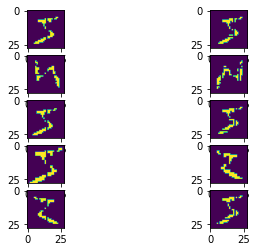

In [190]:
figure, axis = plt.subplots(5, 2)

axis[0, 0].imshow(plot_preprocessing(default))
axis[0, 1].imshow(plot_preprocessing(canonical_transformation(default, default)))

axis[1, 0].imshow(plot_preprocessing(rotated))
axis[1, 1].imshow(plot_preprocessing(canonical_transformation(rotated, default)))

axis[2, 0].imshow(plot_preprocessing(translated))
axis[2, 1].imshow(plot_preprocessing(canonical_transformation(translated, default)))

axis[3, 0].imshow(plot_preprocessing(scaled))
axis[3, 1].imshow(plot_preprocessing(canonical_transformation(scaled, default)))

axis[4, 0].imshow(plot_preprocessing(flipped))
axis[4, 1].imshow(plot_preprocessing(canonical_transformation(flipped, default)))

In [2599]:
def rot(xy, angle):
    m = c_mass(xy)
    xy = xy - m.view(1, 1, 2) * (xy[:, :, 0] != 0).view(1, -1, 1)
    M = torch.Tensor([
        [torch.cos(angle), -torch.sin(angle)],
        [torch.sin(angle), torch.cos(angle)]
    ])
    xy = M @ xy[0].T
    return xy.T[None]

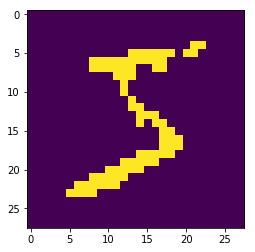

In [101]:
plt.imshow(plot_preprocessing1(rot(default, torch.Tensor([0 * np.pi / 180]))))

In [29]:
angles = torch.linspace(0, 2*3.14, 50)
m_20 = []
m_02 = []
m_11 = []
for a in angles:
    m_20_, m_02_, m_11_ = canonical_transformation(rot(default, a))
    m_20.append(m_20_.item())
    m_02.append(m_02_.item())
    m_11.append(m_11_.item())
m_20 = np.array(m_20)
m_02 = np.array(m_02)
m_11 = np.array(m_11)

In [105]:
angles = torch.linspace(0, 2*3.14, 50)
angle_pred = []
for a in angles:
    angle_pred.append(canonical_transformation(rot(default, a)))
angle_pred = np.array(angle_pred) * 180 / 3.14

No handles with labels found to put in legend.


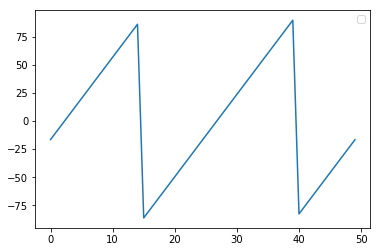

In [106]:
# plt.plot(m_20 - m_02, label='X')
# plt.plot(2 * m_11, label='Y')
# plt.plot([0] * len(m_11))
plt.plot(angle_pred)
# plt.plot(ls/2)
plt.legend(loc='best')


In [129]:
#rotated = dataset2[0][0]
#print(mu(rotated,1,1))
##print(mu(default,2,0))
#print(mu(default,0,2))
#print(mu(default,1,1))

r = mu(rotated,1,1)
q = mu(default,1,1)
p = mu(default,2,0) - mu(default,0,2)

print(r)
print(q)
print(p)

rotation_alpha(q, p, r)

tensor([806.5897])
tensor([-721.1772])
tensor([2228.7344])


NameError: name 'rotation_alpha' is not defined

##### $$
\mathbf{M} = \frac{\sum_i \mathbf{r_i} * m_i}{\sum_i m_i}
$$

$$
\mathbf{M}' = \frac{\sum_i [\mathbf{r_i} + \pmb{\delta}] * m_i}{\sum_i m_i}
= \frac{\sum_i \mathbf{r_i}* m_i}{\sum_i m_i} + \frac{\sum_i \pmb{\delta}* m_i}{\sum_i m_i}
= \mathbf{M} + \pmb{\delta}
$$

In [2297]:
torch.arcsin(torch.tensor(1))

tensor(1.5708)

In [49]:
np.arctan2(60, -1) * 180 / 3.14

91.00097486993334

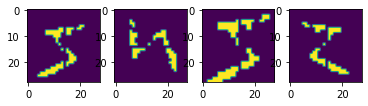

In [192]:
figure, axis = plt.subplots(1, 4)

axis[0].imshow(plot_preprocessing(translated))
axis[1].imshow(plot_preprocessing(rotated))
axis[2].imshow(plot_preprocessing(scaled))
axis[3].imshow(plot_preprocessing(flipped))

tensor([-514.8615])
tensor([111.5054])
tensor([-1771.0990])
tensor([-1099.6249])


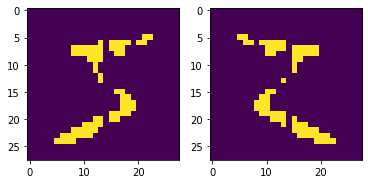

In [191]:
figure, axis = plt.subplots(1, 2)

axis[0].imshow(plot_preprocessing(default))
axis[1].imshow(plot_preprocessing(flipped))

print(mu(default,3,0))
print(mu(default,0,3))
print(mu(flipped,3,0))
print(mu(flipped,0,3))

#print(mu(default,0,3))
#print(mu(rotated,0,3))
#print(mu(scaled,0,3))
#print(mu(flipped,0,3))
#print(mu(translated,0,3))

In [91]:
default

tensor([[[-9.,  7.],
         [-9.,  8.],
         [-8., -1.],
         [-8.,  0.],
         [-8.,  1.],
         [-8.,  2.],
         [-8.,  3.],
         [-8.,  4.],
         [-8.,  6.],
         [-8.,  7.],
         [-7., -6.],
         [-7., -5.],
         [-7., -4.],
         [-7., -3.],
         [-7., -2.],
         [-7., -1.],
         [-7.,  0.],
         [-7.,  1.],
         [-7.,  2.],
         [-7.,  3.],
         [-6., -6.],
         [-6., -5.],
         [-6., -4.],
         [-6., -3.],
         [-6., -2.],
         [-6., -1.],
         [-6.,  2.],
         [-6.,  3.],
         [-5., -3.],
         [-5., -2.],
         [-5., -1.],
         [-4., -2.],
         [-3., -2.],
         [-2., -1.],
         [-1., -1.],
         [-1.,  0.],
         [ 0.,  0.],
         [ 0.,  1.],
         [ 0.,  2.],
         [ 1.,  2.],
         [ 1.,  3.],
         [ 2.,  3.],
         [ 2.,  4.],
         [ 3.,  3.],
         [ 3.,  4.],
         [ 3.,  5.],
         [ 4.,  3.],
         [ 4.